# SAM

In [ ]:
import cmath
import numpy as np
from numpy import pi
import pandas as pd
from typing import List, Iterable
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# значение арктангенса в градусах от 0 до 360
np.degrees(np.arctan(6/5) + 2*pi) % 360
# аналогичный рез, только уже удобнее с комплексными
z = complex(5,6)
np.degrees(cmath.phase(z) + 2*pi) % 360
# реальная и мнимая части
print (z.real)
print (z.imag)

5.0
6.0


SAM - support angle machine\

\begin{align}
\ w =
  \begin{cases}
    w - lr  (2  \lambda  w)       & \quad \text{if True}\\
    w - lr  (({x_I * y_I},{x_R * y_R})-2  \lambda  w_0), w_0=w_0 -lr*y_{idx}   & \quad \text{Else}
  \end{cases}
\
\end{align}

Condition:
\begin{align}
\\|arctan{(\frac{y_I}{y_R})} - arctan{(\frac{X_I * w_I}{X_R * w_R} - w_0)} |\leq \frac {360}{quantity_{classes} * 2}
\end{align}

Сам алгоритм обучения выглядит схожим образом (если идти через градиентный спуск, то как бе без разницы берешь ты производную от переменной помноженной на действительное или комплексное число)

Загвоздочка заключается именно в том, что мы все же не используем комплексные по максимому (то есть избегаем свойства i^2 = -1 - при обучении алгоритма появилась бы серьезная путаница со знаками), да и, в целом, отходим от разделения классов гиперплоскостью. Поскольку у нас теперь все просходит в комплексном пространстве, мы можем взять за основу саму комплексную плоскость, равномерно поделить ее на классы и домножать объекты на веса таким образом, чтобы УГОЛ ИТОГОВОГО ЗНАЧЕНИЯ БЫЛ НАИБЛИЖАЙШИМ 
К УГЛУ НУЖНОГО КЛАССА, воть.

То есть по сути в условии мы требуем, чтобы разница между углом нужного класса и углом получившегося ответа была в нужном диапозоне

In [ ]:
class SAM:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.classes = None

    def to_degrees(z):
      return np.degrees(cmath.phase(z) + 2 * pi) % 360

    def find_class(X_array, classes_list):
      array_angles = list(map(lambda z: to_degrees(z), classes_list))
      prediction = to_degrees(X_array)
      res = abs(np.array(array_angles) - prediction)
      class_ = np.where(res == np.min(res))
      return classes_list[class_]


    def fit(self, X, y):
        n_samples, n_features = X.shape


        # написать для произвольного количества классов
        #y_ = np.where(y <= 0, -1, 1)
        # Допустим у нас все классы изначально правильно написаны
        
        self.classes = np.unique(y)
        self.w = np.zeros(n_features)
        self.b = 0

        classes_q = len(self.classes)
        angle_turn = 360 / (classes_q * 2)        


        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
              #изменить условие DONE
                condition = abs(to_degrees(y_[idx]) - 
                to_degrees(complex((np.dot(np.real(x_i), self.w.real.T) - self.b.real), 
                            np.dot(np.imag(x_i), self.w.imag.T) - self.b.imag))) <= angle_turn
                if condition:
                  # ----------------------
                  # тут понять, что делать с реальными и комплексными частями, чтобы уменьшить угол
                  # думаю у мнимой части нужно только, чтобы знак совпадал (тогда нужно задуматься, как делить плоскость), а оптимизировать уже реальную часть
                  # ----------------------
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]      


    def predict(self, X):

        # находим комплексные значения
        res_real = list(map(lambda x: np.dot(np.real(X), self.w.real.T) - self.b.real, X))
        res_imag = list(map(lambda x: np.dot(np.imag(X), self.w.imag.T) - self.b.imag, X))
        complex_res = list(map(lambda x, y: complex(x, y), res_real, res_imag))

        #узнать наименьшую разницу между ответами и классами по углу # DONE
        res = list(map(lambda x, y: find_class(x, y), complex_res, self.classes))
        
        return res

In [ ]:
np.angle(-1-8j)

#x = np.array([-1+8j, 1-20j])
#b = np.array([-2+10j, -1-2j])
#(np.angle(x) - np.angle(b))**2

def to_degrees(z):
  return np.degrees(np.angle(z) + 2 * pi) % 360

def to_degrees_x_w(X, w):
  i = np.dot(np.imag(X), np.imag(w))
  r = np.dot(np.real(X), np.real(w))
  return np.degrees(np.arctan(i/r) + 2*pi) % 360
to_degrees(-1-8j)

262.8749836510982

Суть решения задач минимизации с условиями:\

1) **Задача Лагранжа** - составляем задачу минимизации и добавляем условия, решение через линейное программирование\
2) **Градиентный спуск** - составляем задачу минимизации и добавляем условия, ВЫРАЖАЕМ все условия в равенства и подставляем их в задачу минимизации. Берем градиент и считаем по формуле градиентного спуска

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(12345)

# сделать w_0

data_r = np.random.uniform(-2,2,10000)
data_i = np.random.uniform(-4,4,10000)
data_new = np.array(list(map(lambda x, y: complex(x,y), data_r, data_i)))

data_new = np.append(np.ones(1000) + 1j, data_new, 0)
data_new = data_new.reshape(11, 1000)
data_w = pd.DataFrame(data_new).T


condition_r = abs(data_w[3] + data_w[7] / data_w[6] ** 2 - data_w[1]) >= 3
condition_i = abs(data_w[3]**3 - data_w[7] * data_w[6] * 2 + data_w[1] / data_w[8]) >= 13

# condition_r = abs(data_w[3] + data_w[7]) >= 3
# condition_i = abs(data_w[4] - 2 * data_w[2]) <= 6

y_r = np.where(condition_r, -1, 1)

y_i = np.where(condition_i, -1, 1)

data_w['y'] = np.array(list(map(lambda x, y: complex(x,y), y_r, y_i)))
X = data_w.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, data_w['y'], test_size=0.3, random_state=10)


In [ ]:
data_w

,0,1,2,3,4,5,6,7,8,9,10,y
0,1.000000+1.000000j,1.718464+0.981627j,1.190578+0.013602j,-0.059319+1.311598j,1.705195-2.480726j,1.291807-0.317956j,0.636224-0.631071j,-0.875551-1.028746j,-0.580340-3.627288j,1.035125-1.796036j,1.685074+3.613994j,1.000000+1.000000j
1,1.000000+1.000000j,-0.734498-3.318712j,0.891083-3.948494j,-0.003116-3.171931j,1.251443-1.285652j,-0.778911-2.341820j,0.418259+1.522316j,1.429454-3.033519j,1.337281-2.376406j,1.098860-0.770936j,-0.414090+0.048036j,1.000000-1.000000j
2,1.000000+1.000000j,-1.264325-2.696190j,1.203564-0.258908j,1.250580+1.604152j,0.994786+0.580474j,0.392131-3.715118j,-1.630219+2.146780j,-1.985138+3.345818j,-0.541701+3.054576j,1.687473+1.393819j,1.579581-1.447367j,-1.000000-1.000000j
3,1.000000+1.000000j,-1.181759+0.454291j,1.886731-1.592856j,1.880429+3.752134j,-1.373159+2.749861j,0.990555-2.603910j,-0.191413-2.741448j,-0.152287-0.756293j,-0.135190+3.206588j,-0.036158-1.363823j,-1.184810-1.647515j,-1.000000-1.000000j
4,1.000000+1.000000j,0.270900+2.426351j,1.510000+1.201727j,-0.242279+0.894871j,-1.107074+3.956199j,1.564285-3.474959j,1.253537-0.972962j,-0.285058-3.223589j,-1.120123+0.612423j,0.228499+2.631181j,1.937589+2.442136j,1.000000+1.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.000000+1.000000j,-1.983003-0.881949j,-0.007335-3.432416j,-0.730972-2.974275j,0.677168+2.032576j,-0.327264+1.783205j,-0.560829-2.909557j,1.116166-2.609633j,0.894242-0.445881j,-0.456554+0.501950j,0.926951+3.772348j,1.000000-1.000000j
996,1.000000+1.000000j,0.239426+2.339018j,0.390049+1.633942j,1.004906+0.584963j,0.635468+2.794657j,-1.373098+0.679753j,1.094913-1.112487j,-1.110485-2.465620j,-1.768333-3.471019j,1.809229-1.862526j,0.555430+3.215737j,1.000000+1.000000j
997,1.000000+1.000000j,1.007119+0.095932j,0.174239+3.039033j,0.503668-3.485937j,-1.298118+2.717122j,-1.264037-1.907788j,1.965116+0.011806j,0.605099-2.810358j,-1.628874+0.994278j,0.402053-0.128539j,-1.923738+2.594204j,-1.000000-1.000000j
998,1.000000+1.000000j,-0.439821+0.650749j,1.792094-2.834797j,-0.158797-2.317654j,0.936549+0.436136j,0.955026-1.948540j,-0.671616+0.674778j,-1.426953-1.087686j,0.757893-3.473710j,1.432231+1.816265j,-0.962152-3.702996j,-1.000000+1.000000j


In [ ]:
w_r = np.random.uniform(-2,2,10)
w_i = np.random.uniform(-2,2,10)
w = np.array(list(map(lambda x, y: complex(x,y), w_r, w_i)))
w = np.append(np.array([1+1j]), w, 0)

In [ ]:
w

array([ 1.        +1.j        , -1.71853575-0.19003469j,
       -1.26864871+0.577966j  , -0.42293765+0.85981154j,
       -1.74328298-0.75852645j, -1.97526777+1.44609314j,
        0.51820057-1.92556717j,  1.99560079+0.41462441j,
       -0.6057971 -0.95064584j, -0.75635045+1.37328534j,
       -1.81844265-0.55542669j])

In [ ]:
np.linalg.norm(w)

4.933326081798542

In [ ]:
np.dot(np.real(y_train), np.dot(np.real(X_train), w))

251.05232913868724

In [ ]:
def norm(v):
  return np.sqrt(np.dot(np.real(v).T, np.real(v)) + np.dot(np.imag(v).T, np.imag(v)))
def norm_x_w(X, w):
  v_r = np.dot(np.real(X), np.real(w))
  v_i = np.dot(np.imag(X), np.imag(w))
  return np.sqrt(np.dot(v_r.T, v_r) + np.dot(v_i.T, v_i))

In [ ]:
def calc_loss(X_train, y_train, w, lamb=0.1, mu=0.1):
  answer = - sum_parts(X_train, y_train, w) / (norm(y_train)* norm_x_w(X_train, w)) + lamb * np.linalg.norm(np.real(w)) ** 2 + mu * np.linalg.norm(np.imag(w)) ** 2
  return answer

def sum_parts(X_train, y_train, w):
  return (np.dot(np.real(y_train), np.dot(np.real(X_train), np.real(w))) + np.dot(np.imag(y_train), np.dot(np.imag(X_train), np.imag(w))))


def calc_grad_r(X_train, y_train, w, lamb=0.1):
  answer = - np.dot(np.real(y_train), np.real(X_train)) / ((norm(y_train)* norm_x_w(X_train, w))) - 2 * sum_parts(X_train, y_train, w) * np.dot(np.dot(np.real(X_train).T, np.real(X_train)), np.real(w)) / (norm(y_train) * (norm_x_w(X_train, w)) ** (4/3))
  answer += lamb * np.real(w) / np.linalg.norm(np.real(w))
  return answer

def calc_grad_i(X_train, y_train, w, mu=0.1):
  answer = - np.dot(np.imag(y_train), np.imag(X_train)) / ((norm(y_train)* norm_x_w(X_train, w))) - 2 * sum_parts(X_train, y_train, w) * np.dot(np.dot(np.imag(X_train).T, np.imag(X_train)), np.imag(w)) / (norm(y_train) * (norm_x_w(X_train, w)) ** (4/3))
  answer += mu * np.imag(w) / np.linalg.norm(np.imag(w))
  return answer

def gradient_descent(X, y, w, n_iterations, w_list, lr=0.1):
    w_list = []
    for i in range(n_iterations):
        gradient_r = calc_grad_r(X, y, w)
        w = w - lr * gradient_r
        gradient_i = calc_grad_i(X, y, w)
        w = w - lr * gradient_i
        w_list.append(w)
    return w_list

def to_degrees(z):
  return np.degrees(np.angle(z) + 2 * pi) % 360

def class_definder(coordinate):
  answer = to_degrees(coordinate)
  if answer >= 0 and answer < 90:
    return 1+1j
  elif answer >= 90 and answer < 180:
    return -1+1j
  elif answer >= 180 and answer < 270:
    return -1-1j
  else :
    return 1-1j

def predict(X, w):
  coordinate = np.dot(X, w)
  y = list(map(lambda x: class_definder(x), coordinate))
  y_coordinate = list(map(lambda x: to_degrees(x), coordinate))
  return y, coordinate




In [ ]:
w_list = []
a = gradient_descent(X_train, y_train, w, 10000, w_list)


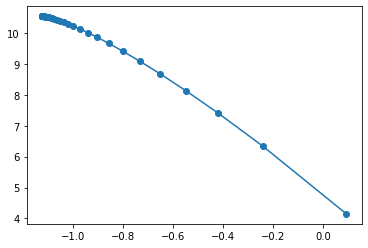

In [ ]:
plt.scatter(np.real(a)[:, 0], np.real(a)[:, 1])
plt.plot(np.real(a)[:, 0], np.real(a)[:, 1])

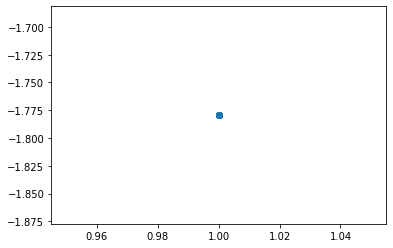

In [ ]:
plt.scatter(np.imag(a)[:, 0], np.imag(a)[:, 1])
plt.plot(np.imag(a)[:, 0], np.imag(a)[:, 1])

In [ ]:
w = a[-1]
y, y_c = predict(X_test, w)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


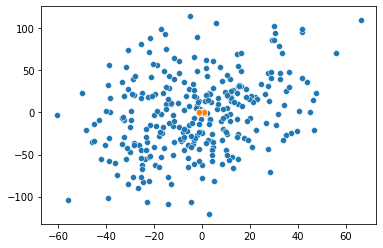

In [ ]:
sns.scatterplot(np.real(y_c), np.imag(y_c))
sns.scatterplot(np.real(y_test), np.imag(y_test))
#np.real(y)

In [ ]:
accuracy = np.where(y_test - y == 0+0j)
len(accuracy[0]) # 74 правильных ответа из 300)))))

74

In [ ]:
np.unique(y - y_test)

array([-2.-2.j, -2.+0.j, -2.+2.j,  0.-2.j,  0.+0.j,  0.+2.j,  2.-2.j,
        2.+0.j,  2.+2.j])

In [ ]:
# попробовать через экспоненту